In [51]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import hashlib
import matplotlib.ticker as ticker
def nd(arr):
    return np.asarray(arr).reshape(-1)

def yex(ax):
    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
        np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
    ]

    # now plot both limits against eachother
    ax.plot(lims, lims, c="k", alpha=0.75, zorder=0)
    ax.set(**{"aspect": "equal", "xlim": lims, "ylim": lims})
    return ax

def short_hash(s: str) -> str:
    """Generate a 7-character hash from a given string."""
    return hashlib.sha256(s.encode()).hexdigest()[:7]

fsize = 15
plt.rcParams.update({"font.size": fsize})
%config InlineBackend.figure_format = 'retina'

In [52]:
# #522600 brown
# #307351 green
# #1C6087 blue
# #F75C03 orange
# #FFBA08 yellow


COLOR = {
    "source": "33658A",
    "target": "F6AE2D",
    "whitespace": "",
    "token": "",
    "taln": "",
    "difflib": "",
    "lcs": "",
    "naive": "",
}

In [53]:
from taln.taln_aln import (
    norm_text,
    tokenize,
    align_ng, 
    align_lcs,
    align_difflib,
    reconstruct_target_by_token,
)

In [54]:
cols = ["title", "question", "question_id", "is_impossible", "answer_type"]

In [55]:
# BOAT (pre-grouped) frames written by analysis/make_ds.ipynb
tdf_t = pd.read_json("../data/boat_train.tdf.json", orient="records")
tdf_d = pd.read_json("../data/boat_dev.tdf.json", orient="records")
tdf = pd.concat([tdf_t, tdf_d])

wdf_t = pd.read_json("../data/boat_train.wdf.json", orient="records")
wdf_d = pd.read_json("../data/boat_dev.wdf.json", orient="records")
wdf = pd.concat([wdf_t, wdf_d])

# idx_start is stored as a JSON list; convert back to set to match downstream code
tdf["idx_start"] = tdf["idx_start"].apply(set)
wdf["idx_start"] = wdf["idx_start"].apply(set)

In [56]:
wdf.shape, tdf.shape, wdf.source.nunique(), tdf.source.nunique()

((35080, 3), (35080, 3), 14701, 14701)

In [57]:

# #522600 brown
# #307351 green
# #7EC9A2 light green
# #1C6087 blue
# #FE640B orange
# #FEA571 light orange
# #FFBA08 yellow

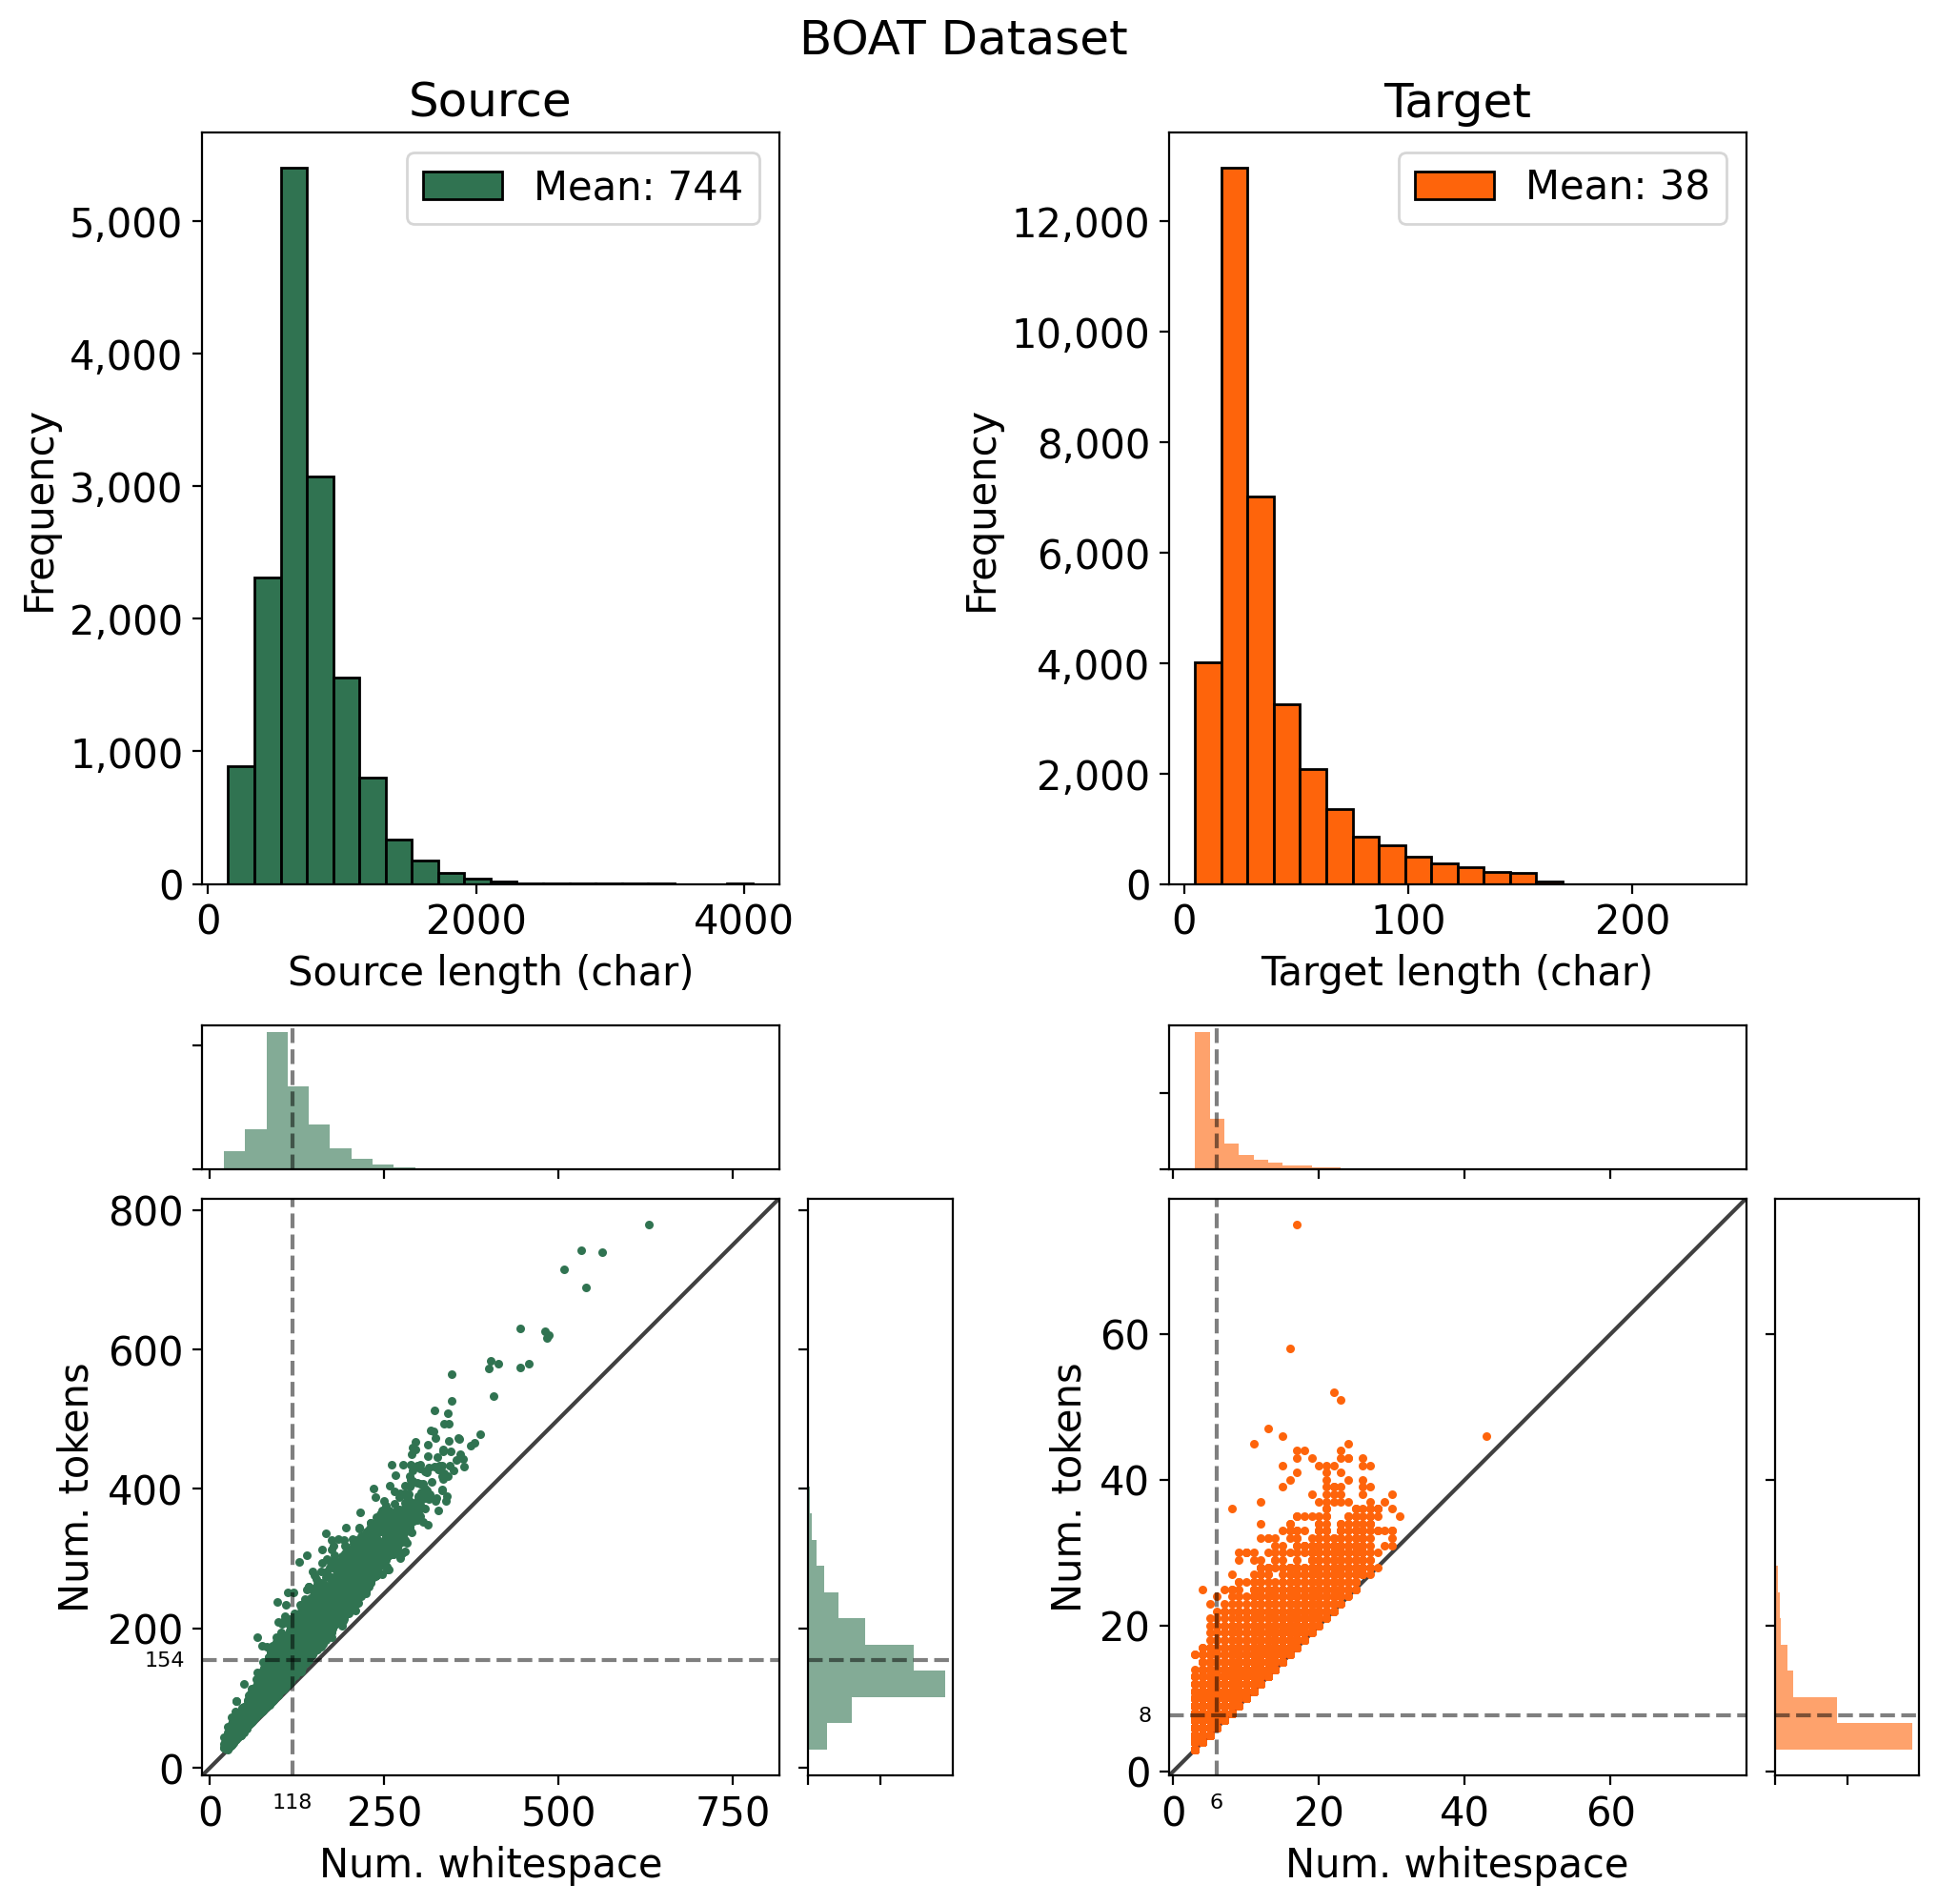

In [58]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

def scatter_with_marginals(ax, x, y, color):
    ax.scatter(x, y, s=5, color=color)
    ax.set(
        xlabel="Num. whitespace",
        ylabel="Num. tokens",
    )
    mnx = x.mean()
    mny = y.mean()

    # vertical mean line
    ax.axvline(mnx, linestyle="--", color="k", alpha=0.5)
    ax.text(
        mnx, -0.03,                     # x in data coords, y just below axis
        f"{mnx:.0f}",
        transform=ax.get_xaxis_transform(),
        ha="center", va="top",
        fontsize=8,
    )

    # horizontal mean line
    ax.axhline(mny, linestyle="--", color="k", alpha=0.5)
    ax.text(
        -0.03, mny,                    # x just left of axis, y in data coords
        f"{mny:.0f}",
        transform=ax.get_yaxis_transform(),
        ha="right", va="center",
        fontsize=8,
    )

    # top marginal
    ax_histx = ax.inset_axes([0, 1.05, 1, 0.25], sharex=ax)
    ax_histx.hist(x, bins=20, color=color, alpha=0.6)
    plt.setp(ax_histx.get_xticklabels(), visible=False)
    ax_histx.tick_params(axis="y", labelleft=False)
    ax_histx.axvline(mnx, linestyle="--", color="k", alpha=0.5)

    # right marginal
    ax_histy = ax.inset_axes([1.05, 0, 0.25, 1], sharey=ax)
    ax_histy.hist(y, bins=20, orientation="horizontal", color=color, alpha=0.6)
    ax_histy.tick_params(axis="x", labelbottom=False)
    ax_histy.axhline(mny, linestyle="--", color="k", alpha=0.5)

    plt.setp(ax_histy.get_yticklabels(), visible=False)
    yex(ax)


# fig, axs = plt.subplots(figsize=(10, 10), ncols=2, nrows=2, constrained_layout=True)
# fig.suptitle("BOAT Dataset")

fig = plt.figure(figsize=(10, 10), layout="constrained")
gs = fig.add_gridspec(
    2, 2,
)
axs = gs.subplots()
fig.suptitle("BOAT Dataset")

# ===============================
# TOP ROW — HISTOGRAMS
# ===============================

# --- SOURCE ---
ax = axs[0, 0]

x = pd.Series(wdf.source.unique()).str.len()
mn = x.mean()
ax.hist(x.values, bins=20, edgecolor="k", facecolor="#307351", label=f"Mean: {mn:,.0f}")
ax.set(xlabel="Source length (char)", ylabel="Frequency", title="Source")
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: f"{int(x):,}"))
ax.legend()

# --- TARGET ---
ax = axs[0,1]

x = pd.Series(wdf.target.unique()).str.len()
mn = x.mean()
ax.hist(x.values, bins=20, edgecolor="k", facecolor="#FE640B", label=f"Mean: {mn:,.0f}")
ax.set(xlabel="Target length (char)", ylabel="Frequency", title="Target")
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: f"{int(x):,}"))
ax.legend()

# ===============================
# SECOND ROW — SCATTER + MARGINALS
# ===============================

# --- SOURCE ---
ax = axs[1, 0]

ws = pd.Series(tdf.source.unique()).apply(lambda s: len(s.split()))
toks = pd.Series(tdf.source.unique()).apply(lambda s: len(tokenize(s)[0]))

scatter_with_marginals(ax, ws, toks, "#307351")

# --- TARGET ---
ax = axs[1, 1]

ws = pd.Series(tdf.target.unique()).apply(lambda s: len(s.split()))
toks = pd.Series(tdf.target.unique()).apply(lambda s: len(tokenize(s)[0]))

scatter_with_marginals(ax, ws, toks, "#FE640B")

plt.show()

In [59]:
import pandas as pd

def compute_stats(texts_w, texts_t):
    chars = texts_w.str.len()
    ws = texts_w.apply(lambda s: len(s.split()))
    toks = texts_t.apply(lambda s: len(tokenize(s)[0]))
    return {
        "Char/Sample": chars.mean(),
        "WS/Sample": ws.mean(),
        "Tok/Sample": toks.mean(),
        "N Samples": texts_w.nunique()
    }

source_stats = compute_stats(
    pd.Series(wdf.source.unique()),
    pd.Series(tdf.source.unique())
)

target_stats = compute_stats(
    pd.Series(wdf.target.unique()),
    pd.Series(tdf.target.unique())
)

table = pd.DataFrame([source_stats, target_stats], index=["source", "target"])
table = table.round(0)
table

,Char/Sample,WS/Sample,Tok/Sample,N Samples
source,744.0,118.0,154.0,14701
target,38.0,6.0,8.0,33838


In [60]:
import time
# Apply function with timing
def timed_align(x, fn, ttype): # fn takes in source and target
    start_time = time.time()
    ctx = x["source"]
    tgt = x["target"]

    if ttype == 'whitespace':
        tgt = tgt.strip()

    result = fn(ctx, tgt, ttype)
    end_time = time.time()

    # Calculate elapsed time in milliseconds
    t = (end_time - start_time) * 1000
    return result, t

def align_naive(ctx, tgt, ttype):
    if tgt in ctx:
        idx = ctx.index(tgt)
        found = {
            "token": tgt,
            "enc_token": -1, 
            "start_idx": ctx.index(tgt),
            "end_idx": idx + len(tgt),
        }
        return [[found]]
    else:
        return [[]]

methods = {
    "custom": align_ng,
    "lcs": align_lcs,
    "difflib": align_difflib,
    "naive": align_naive,
}

In [61]:
for m in methods:
    # alignments and time
    tdf[[f"{m}_aln", f"{m}_time_ms"]] = tdf.apply(
        timed_align, axis=1, result_type="expand", args=(methods[m],"token")
    )

    # num alignments
    tdf[f"{m}_len"] = tdf[f"{m}_aln"].apply(len)

    tdf[f"{m}_idx_start"] = tdf[f"{m}_aln"].apply(lambda x: set([i[0].get("start_idx", -1) for i in x]) if len(x)>0 and len(x[0])>0 else {-1})

    tdf[f"{m}_text"] = tdf[f"{m}_aln"].apply(lambda x: reconstruct_target_by_token("", x[0] if len(x)>0 else ""))
    tdf[f"{m}_same"] = tdf["target"] == tdf[f"{m}_text"]


In [62]:
for m in methods:
    # alignments and time
    wdf[[f"{m}_aln", f"{m}_time_ms"]] = wdf.apply(
        timed_align, axis=1, result_type="expand", args=(methods[m], "whitespace")
    )

    # num alignments
    wdf[f"{m}_len"] = wdf[f"{m}_aln"].apply(len)

    wdf[f"{m}_idx_start"] = wdf[f"{m}_aln"].apply(lambda x: set([i[0].get("start_idx", -1) for i in x]) if len(x)>0 and len(x[0])>0 else {-1})

    wdf[f"{m}_text"] = wdf[f"{m}_aln"].apply(lambda x: reconstruct_target_by_token("", x[0] if len(x)>0 else "", " "))
    wdf[f"{m}_same"] = wdf["target"].str.strip() == wdf[f"{m}_text"].str.strip()

In [63]:
# compare to the start
def compute_set_operations(x, real_idx="idx_start", pred_idx="custom_idx_start", vals=False):
    set1 = x[real_idx]
    set2 = x[pred_idx]

    left_diff = set1 - set2  # Elements in set1 but not in set2
    intersection = set1 & set2  # Common elements
    right_diff = set2 - set1  # Elements in set2 but not in set1

    if vals:
        return pd.Series([left_diff, intersection, right_diff])
    else:
        return pd.Series([len(left_diff), len(intersection), len(right_diff)])

# token ops
for m in list(methods.keys()):

    tdf[[f"{m}_lv", f"{m}_xv", f"{m}_rv"]] = tdf.apply(lambda x: compute_set_operations(x, real_idx= "idx_start", pred_idx=f"{m}_idx_start", vals=True), axis=1)
    tdf[[f"{m}_l", f"{m}_x", f"{m}_r"]] = tdf.apply(lambda x: compute_set_operations(x, real_idx= "idx_start", pred_idx=f"{m}_idx_start"), axis=1)
    tdf[f"{m}_found"] = tdf.apply(
        lambda x: x[f"{m}_l"] == 0, axis=1
    )

# whitespace ops
for m in list(methods.keys()):

    wdf[[f"{m}_lv", f"{m}_xv", f"{m}_rv"]] = wdf.apply(lambda x: compute_set_operations(x, real_idx= "idx_start", pred_idx=f"{m}_idx_start", vals=True), axis=1)
    wdf[[f"{m}_l", f"{m}_x", f"{m}_r"]] = wdf.apply(lambda x: compute_set_operations(x, real_idx= "idx_start", pred_idx=f"{m}_idx_start"), axis=1)
    wdf[f"{m}_found"] = wdf.apply(
        lambda x: x[f"{m}_l"] == 0, axis=1
    )
    

In [64]:
# custom
print(tdf["custom_same"].sum()/tdf.shape[0]*100)
print(tdf["lcs_same"].sum()/tdf.shape[0]*100)
print(tdf["difflib_same"].sum()/tdf.shape[0]*100)
print(tdf["naive_same"].sum()/tdf.shape[0]*100)

96.17730900798176
96.20866590649943
96.20581527936146
100.0


In [65]:
# custom
print(wdf["custom_same"].sum()/wdf.shape[0]*100)
print(wdf["lcs_same"].sum()/wdf.shape[0]*100)
print(wdf["difflib_same"].sum()/wdf.shape[0]*100)
print(wdf["naive_same"].sum()/wdf.shape[0]*100)

50.19099201824402
50.210946408209814
50.09692132269099
100.0


In [66]:
both = tdf.query("custom_found & naive_found").shape[0]
neither = tdf.query("~custom_found & ~naive_found").shape[0]
found_only = tdf.query("custom_found & ~naive_found").shape[0]
naive_only = tdf.query("~custom_found & naive_found").shape[0]

In [67]:
# Create the original DataFrame
tbl = pd.DataFrame(
    [[both, found_only],
     [naive_only, neither]],
    index=["custom_found True", "custom_found False"],
    columns=["naive_found True", "naive_found False"]
)

# Add row sums
tbl["Total"] = tbl.sum(axis=1)

# Add column sums
tbl.loc["Total"] = tbl.sum(axis=0)
tbl


,naive_found True,naive_found False,Total
custom_found True,34872,0,34872
custom_found False,208,0,208
Total,35080,0,35080


In [68]:
# Create the original DataFrame
tbl = pd.DataFrame(
    [[both, found_only],
     [naive_only, neither]],
    index=["custom_found True", "custom_found False"],
    columns=["naive_found True", "naive_found False"]
)

# Add row sums
tbl["Total"] = tbl.sum(axis=1)

# Add column sums
tbl.loc["Total"] = tbl.sum(axis=0)
tbl / tbl.loc["Total", "Total"] * 100

,naive_found True,naive_found False,Total
custom_found True,99.40707,0.0,99.40707
custom_found False,0.59293,0.0,0.59293
Total,100.00000,0.0,100.00000


In [69]:
times = tdf.assign(ntks_src=tdf["source"].apply(lambda x: len(tokenize(x)[0]))) \
   .groupby("ntks_src")[[
       "custom_time_ms",
       "lcs_time_ms",
       "difflib_time_ms",
       "naive_time_ms",
       ]].mean()
# times = tdf.assign(ntks_src=tdf["source"].apply(lambda x: len(x))) \
#    .groupby("ntks_src")[[
#        "custom_time_ms",
#        "lcs_time_ms",
#        "difflib_time_ms",
#        "naive_time_ms",
#        ]].mean()

In [70]:
def plaw_fit(x, y):
    logx = np.log10(x)
    logy = np.log10(y)
    ceoffs = np.polyfit(logx, logy, 1)
    b, loga = ceoffs
    a = 10**loga

    x_fit = np.logspace(np.log10(min(x)), np.log10(max(x)), 1000)
    y_fit = a * x_fit**b
    return (x_fit, y_fit, a, b)

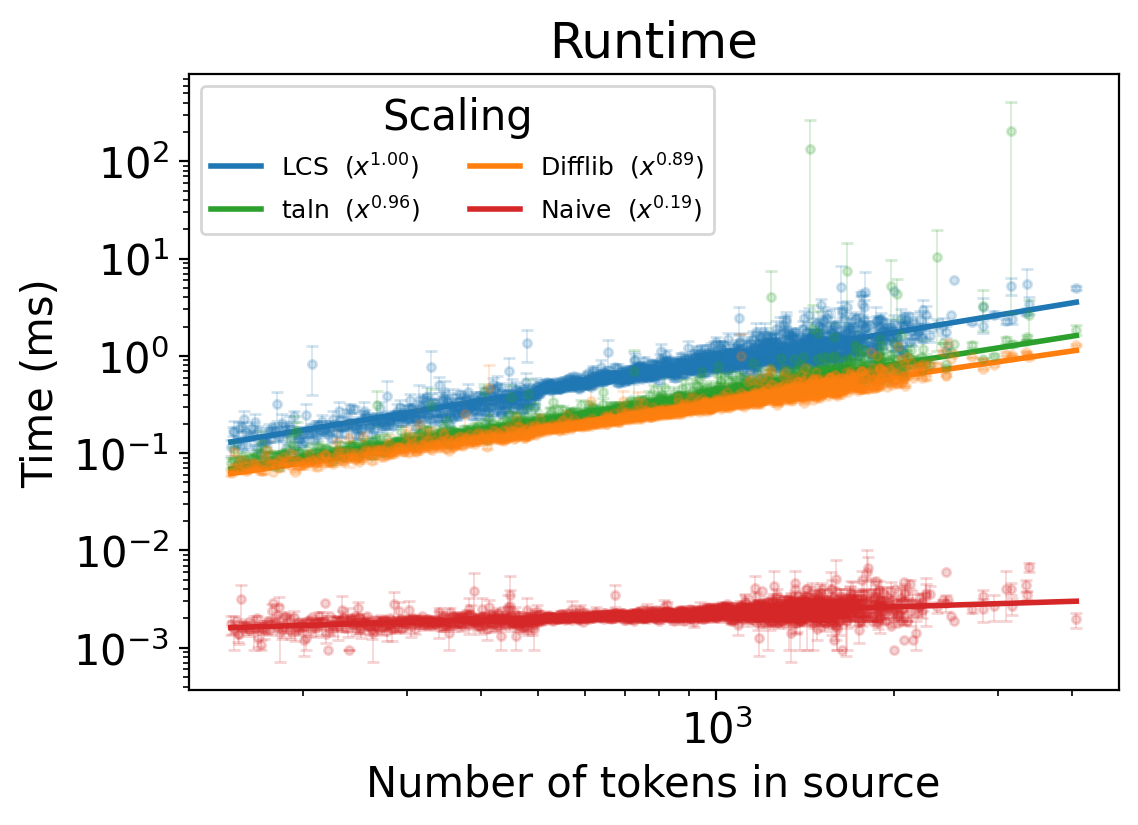

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

METHOD_COLS = [
    "lcs_time_ms",
    "custom_time_ms",   # taln
    "difflib_time_ms",
    "naive_time_ms",
]

LABELS = {
    "lcs_time_ms":     "LCS",
    "custom_time_ms":  "taln",
    "difflib_time_ms": "Difflib",
    "naive_time_ms":   "Naive",
}

# COLORS = {
#     "lcs_time_ms":     "#1f77b4",  # blue
#     "custom_time_ms":  "#ff7f0e",  # orange
#     "difflib_time_ms": "#2ca02c",  # green
#     "naive_time_ms":   "#d62728",  # red
# }


COLORS = {
    "lcs_time_ms":     "#1f77b4",  # blue
    "custom_time_ms":  "#2ca02c",  # green
    "difflib_time_ms": "#ff7f0e",  # orange
    "naive_time_ms":   "#d62728",  # red
}

def plaw_fit(x, y):
    logx = np.log10(x)
    logy = np.log10(y)
    b, loga = np.polyfit(logx, logy, 1)
    a = 10**loga
    x_fit = np.logspace(np.log10(x.min()), np.log10(x.max()), 500)
    y_fit = a * x_fit**b
    return x_fit, y_fit, a, b

# ---- aggregate timings: mean + sem per source length ------------------------
g = (
    tdf.assign(ntks_src=tdf["source"].apply(len))
       .groupby("ntks_src")[METHOD_COLS]
)

means = g.mean()
sems  = g.sem()

x = means.index.values

# ---- plot -------------------------------------------------------------------

fig, ax = plt.subplots(figsize=(6, 4))

for k in METHOD_COLS:
    y_mean = means[k].values
    y_sem  = sems[k].values

    # fit on means
    x_fit, y_fit, a, b = plaw_fit(x, y_mean)

    # line for fitted power law
    ax.plot(
        x_fit, y_fit,
        color=COLORS[k],
        lw=2,
    )

    # points + vertical uncertainty
    ax.errorbar(
        x, y_mean,
        yerr=y_sem,
        fmt="o",
        markersize=3,
        lw=0.6,
        capsize=2,
        color=COLORS[k],
        ecolor=COLORS[k],
        alpha=0.2,
    )

    # concise legend label – focus on scaling
    ax.plot([], [], color=COLORS[k], lw=2,
            label=fr"{LABELS[k]}  ($x^{{{b:.2f}}}$)")

ax.set(
    xlabel="Number of tokens in source",
    ylabel="Time (ms)",
    xscale="log",
    yscale="log",
    title="Runtime"
)

# legend below, horizontal, out of the way
leg = ax.legend(
    loc="upper left",
    # bbox_to_anchor=(0.5, -0.25),
    ncol=2,
    frameon=True,
    fontsize=9,
    title="Scaling"
)

plt.show()

In [ ]:
tacc = tdf.assign(ntks_ctx=tdf["source"].apply(lambda x: len(tokenize(x)[0]))) \
    .groupby("ntks_ctx")[["custom_found", "lcs_found", "difflib_found", "naive_found"]] \
    .agg(lambda x: x.sum() / x.count() * 100)

wacc = wdf.assign(ntks_ctx=wdf["source"].apply(lambda x: len(tokenize(x)[0]))) \
    .groupby("ntks_ctx")[["custom_found", "lcs_found", "difflib_found", "naive_found"]] \
    .agg(lambda x: x.sum() / x.count() * 100)

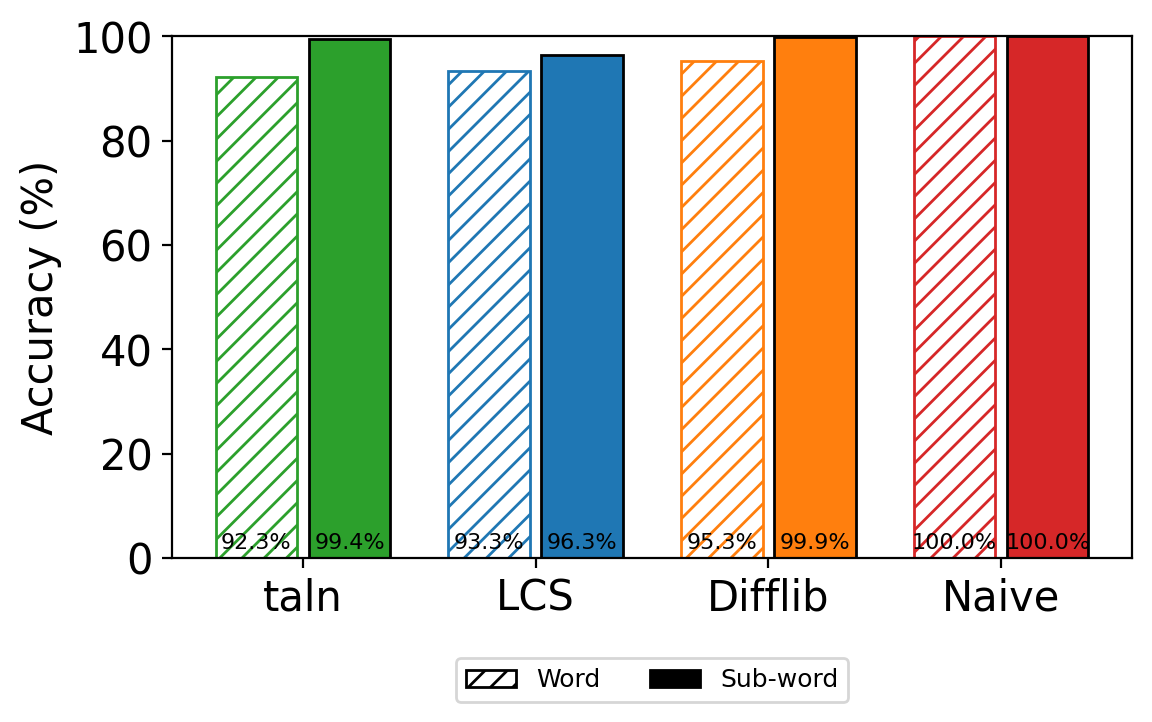

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

COLORS = {
    "lcs":     "#1f77b4",  # blue
    "custom":  "#2ca02c",  # green
    "difflib": "#ff7f0e",  # orange
    "naive":   "#d62728",  # red
}

fig, ax = plt.subplots(figsize=(6, 4))

methods = {"taln": "custom", "LCS": "lcs", "Difflib": "difflib", "Naive": "naive"}
x = np.arange(len(methods.keys()))

width = 0.35
gap = 0.025

# --- sub-word (tacc) ---------------------------------------------------------
for idx, (label, m) in enumerate(methods.items()):
    y = tacc[f"{m}_found"]
    y_mean = np.mean(y)
    center = idx + (width/2 + gap)

    ax.bar(
        center, y_mean, width,
        edgecolor="black",
        facecolor=COLORS[m],   # solid color
        zorder=0,
    )

    ax.text(center, 1, f"{y_mean:.1f}%",
            ha="center", va="bottom", fontsize=8)

# --- word (wacc) -------------------------------------------------------------
for idx, (label, m) in enumerate(methods.items()):
    y = wacc[f"{m}_found"]
    y_mean = np.mean(y)
    center = idx - (width/2 + gap)

    ax.bar(
        center, y_mean, width,
        edgecolor=COLORS[m],
        facecolor="white",
        hatch="///",           # stripes
        linewidth=1,
        zorder=0,
    )

    ax.text(center, 1, f"{y_mean:.1f}%",
            ha="center", va="bottom", fontsize=8)


# --- axes / labels -----------------------------------------------------------
ax.set(
    ylabel="Accuracy (%)",
    xticks=x,
    xticklabels=list(methods.keys()),
    ylim=(0, 100),
    # title="Contiguous alignment",
)

# legend
legend_elements = [
    Patch(facecolor="white", edgecolor="black", hatch="///", label="Word"),
    Patch(facecolor="k", edgecolor="black", label="Sub-word"),
]


ax.legend(
    handles=legend_elements,
    loc="lower center",
    bbox_to_anchor=(0.5, -0.3),
    ncol=2,
    frameon=True,
    fontsize=9,
)

plt.tight_layout()
plt.show()

In [ ]:
tacc.mean(), wacc.mean()

(custom_found      99.447662
 lcs_found         96.339777
 difflib_found     99.885310
 naive_found      100.000000
 dtype: float64,
 custom_found      92.276241
 lcs_found         93.321932
 difflib_found     95.274993
 naive_found      100.000000
 dtype: float64)

In [ ]:
tdf.source.str.split(" ").apply(lambda x: [len(i) for i in x]).explode().mean()

np.float64(5.328801676533154)

In [ ]:
tdf.columns

Index(['source', 'target', 'idx_start', 'custom_aln', 'custom_time_ms',
       'custom_len', 'custom_idx_start', 'custom_text', 'custom_same',
       'lcs_aln', 'lcs_time_ms', 'lcs_len', 'lcs_idx_start', 'lcs_text',
       'lcs_same', 'difflib_aln', 'difflib_time_ms', 'difflib_len',
       'difflib_idx_start', 'difflib_text', 'difflib_same', 'naive_aln',
       'naive_time_ms', 'naive_len', 'naive_idx_start', 'naive_text',
       'naive_same', 'custom_lv', 'custom_xv', 'custom_rv', 'custom_l',
       'custom_x', 'custom_r', 'custom_found', 'lcs_lv', 'lcs_xv', 'lcs_rv',
       'lcs_l', 'lcs_x', 'lcs_r', 'lcs_found', 'difflib_lv', 'difflib_xv',
       'difflib_rv', 'difflib_l', 'difflib_x', 'difflib_r', 'difflib_found',
       'naive_lv', 'naive_xv', 'naive_rv', 'naive_l', 'naive_x', 'naive_r',
       'naive_found'],
      dtype='object')

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# --- Compute per-row token + char counts ------------------------------------
df = tdf.assign(
    n_chars = tdf["source"].apply(len),
    n_tokens = tdf["source"].apply(lambda x: len(tokenize(x)[0])),
)

# --- Compute accuracy per token-length bucket (your existing code) ----------
tacc = (
    tdf.assign(ntks_ctx=tdf["source"].apply(lambda x: len(tokenize(x)[0])))
       .groupby("ntks_ctx")[["custom_found", "lcs_found", "difflib_found", "naive_found"]]
       .agg(lambda x: x.sum() / x.count() * 100)
)

# --- Attach accuracy back to each row ---------------------------------------
# choose which method’s accuracy to plot (change name here)
method = "custom_found"

df = df.assign(
    accuracy = df["n_tokens"].map(tacc[method])
)


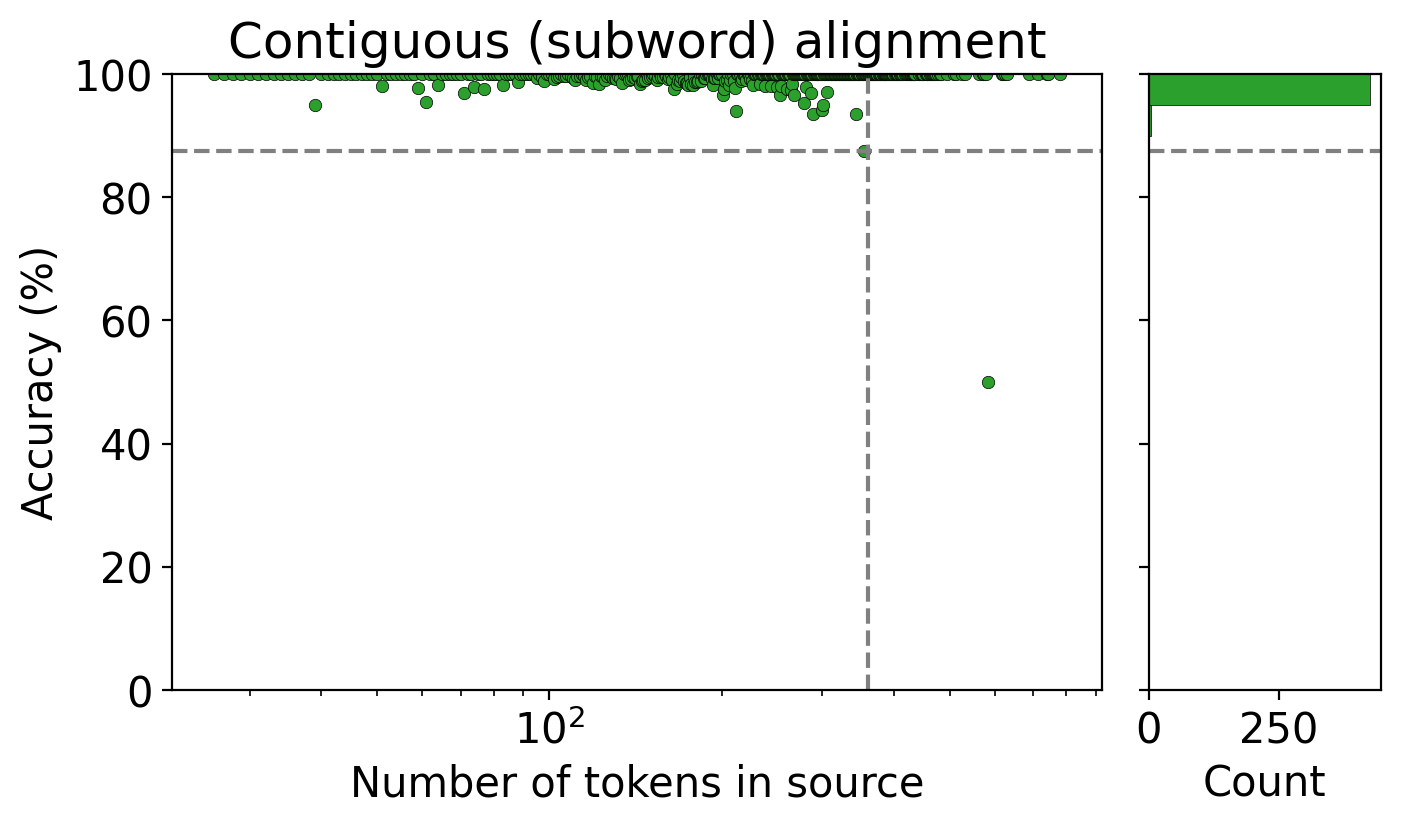

In [79]:
import numpy as np
import matplotlib.pyplot as plt

# --- pick which accuracy to use ---------------------------------------------
method = "custom_found"  # or "lcs_found", "difflib_found", "naive_found"

acc_by_tokens = (
    tacc[method]
    .reset_index()
    .rename(columns={"ntks_ctx": "n_tokens", method: "accuracy"})
    .sort_values("n_tokens")
)

# --- plot: tokens vs accuracy -----------------------------------------------
fig, ax = plt.subplots(figsize=(6, 4))

ax.scatter(
    acc_by_tokens["n_tokens"],
    acc_by_tokens["accuracy"],
    s=20,
    edgecolor="k",
    linewidths=0.25,
    facecolor="#2ca02c",
)

cu_ntks = 360
ax.axvline(cu_ntks, color="grey", linestyle="--")
min_acc = acc_by_tokens.loc[acc_by_tokens["n_tokens"] <= cu_ntks, "accuracy"].min()
ax.axhline(min_acc, color="grey", linestyle="--")

ax.set(
    xlabel="Number of tokens in source",
    ylabel="Accuracy (%)",
    xscale="log",
    ylim=(0, 100),
    title="Contiguous (subword) alignment",
)

# --- right marginal: accuracy distribution -----------------------------------
ax_histy = ax.inset_axes([1.05, 0, 0.25, 1], sharey=ax)

bins = np.arange(0, 101, 5)
ax_histy.hist(
    acc_by_tokens["accuracy"],
    bins=bins,
    orientation="horizontal",
    color="#2ca02c",
    edgecolor="k",
    linewidth=0.25,
)

# same hline on marginal
ax_histy.axhline(min_acc, color="grey", linestyle="--")

ax_histy.tick_params(axis="x", labelbottom=True)
plt.setp(ax_histy.get_yticklabels(), visible=False)

ax_histy.set_xlabel("Count")

plt.show()

In [ ]:
def compute_coverage(aln_list, nutks_ans):
    if len(aln_list) > 0:
        return len(set(i["enc_token"] for i in aln_list[0])) / nutks_ans
    return 0

In [ ]:
# df["custom_coverage"] = df["custom_aln"].apply(lambda x: len(set([i["enc_token"] for i in x[0] if len(x) > 0])) if len(x) > 0 else 0) / df["nutks_ans"]
# df["lcs_coverage"] = df["lcs_aln"].apply(lambda x: len(set([i["enc_token"] for i in x[0] if len(x) > 0])) if len(x) > 0 else 0) / df["nutks_ans"]
# df["difflib_coverage"] = df["difflib_aln"].apply(lambda x: len(set([i["enc_token"] for i in x[0] if len(x) > 0])) if len(x) > 0 else 0) / df["nutks_ans"]

cov = tdf.assign(
    nutks_ans=lambda d: d["target"].apply(lambda x: len(tokenize(x)[0])),
    custom_coverage=lambda d: d.apply(lambda row: compute_coverage(row["custom_aln"], row["nutks_ans"]), axis=1),
    lcs_coverage=lambda d: d.apply(lambda row: compute_coverage(row["lcs_aln"], row["nutks_ans"]), axis=1),
    difflib_coverage=lambda d: d.apply(lambda row: compute_coverage(row["difflib_aln"], row["nutks_ans"]), axis=1),
)

In [ ]:
cov_mean = cov[["nutks_ans", "custom_coverage", "lcs_coverage", "difflib_coverage"]].assign(naive_coverage=1).groupby("nutks_ans").mean()

In [ ]:
# cov = tdf.assign(ntks_ctx=tdf["source"].apply(lambda x: len(tokenize(x)[0]))) \
#     .groupby("ntks_ctx")[["custom_coverage", "lcs_coverage", "difflib_coverage", "naive_coverage"]] \
#     .agg(lambda x: x.sum() / x.count() * 100)

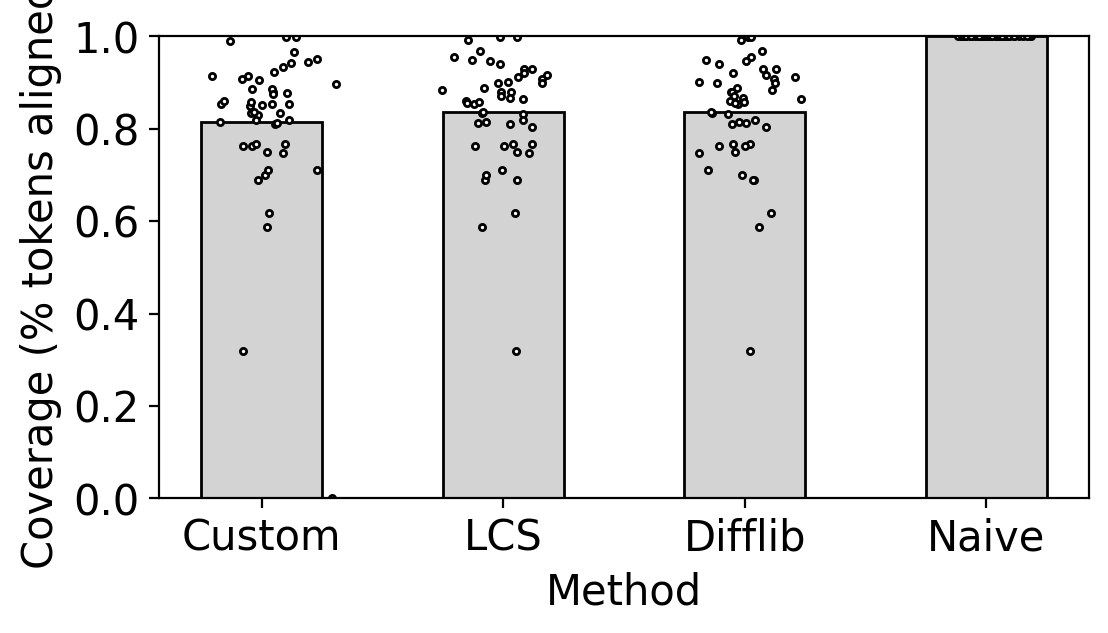

In [ ]:
fig, ax = plt.subplots(figsize=(6,3))

x = np.arange(4)
width = 0.5

for idx, (i, y) in enumerate(cov_mean.items()):
    x = np.random.normal(idx, 0.1, size=len(y))
    ax.scatter(x, y.values, s=5, edgecolors="black", facecolors="white")
    ax.bar(idx, y.mean(), width, label=y.name, zorder=-1, edgecolor="black", facecolor="lightgrey")


ax.set(**{
    "ylabel": "Coverage (% tokens aligned)",
    "xlabel": "Method",
    "xticks": np.arange(4),
    "xticklabels": ["Custom", "LCS", "Difflib", "Naive"],
    "ylim": (0, 1),
})
plt.show()

In [ ]:
LABELS = {'custom_coverage': 'Custom',
          'lcs_coverage': 'LCS',
          'difflib_coverage': 'Difflib',
          'naive_coverage': 'Naive'
          }

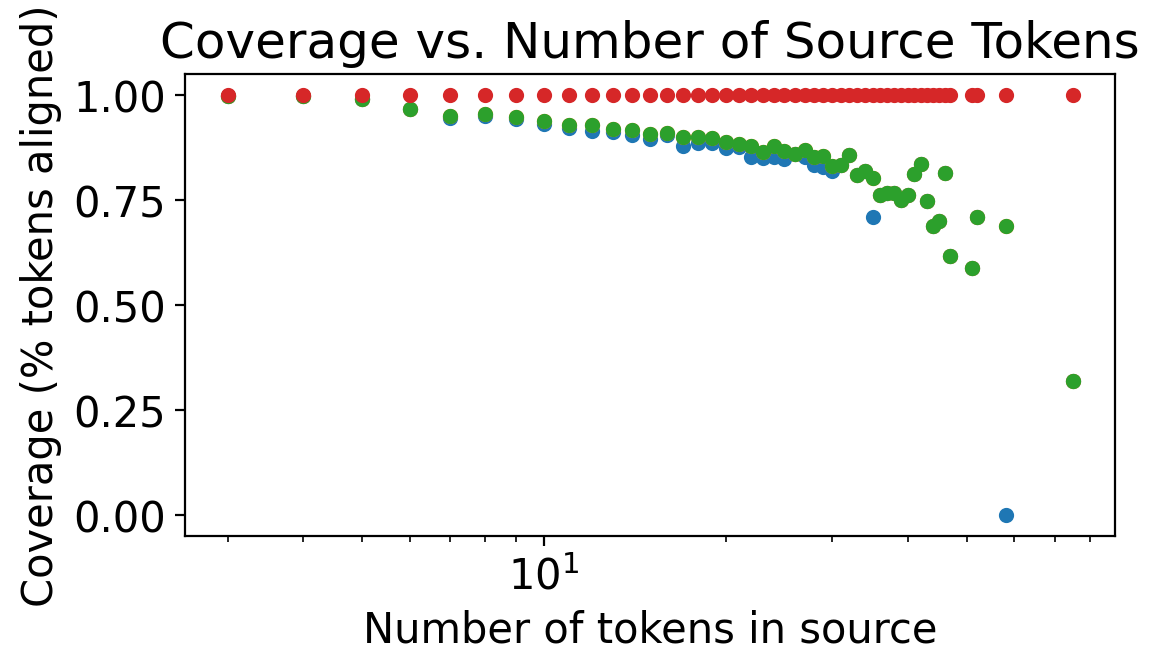

In [ ]:
fig, ax = plt.subplots(figsize=(6, 3))

x = cov_mean.index.values
for k, v in LABELS.items():
    y = cov_mean[k].values

    # plot the curve fit
    ax.scatter(x, y,  label=label, s=20)

ax.set(**{
    "ylabel": "Coverage (% tokens aligned)",
    "xlabel": "Number of tokens in source",
    "xscale": "log",
    # "yscale": "log",
    # "xlim": (10, 1e3),
    "title": "Coverage vs. Number of Source Tokens",
})
plt.show()

In [ ]:
(tdf["custom_found"]).sum()/tdf.shape[0]*100

np.float64(99.40706955530216)

In [ ]:
# custom
print(tdf["custom_same"].sum()/tdf.shape[0]*100)
print(tdf["lcs_same"].sum()/tdf.shape[0]*100)
print(tdf["difflib_same"].sum()/tdf.shape[0]*100)
print(tdf["naive_same"].sum()/tdf.shape[0]*100)

96.17730900798176
96.20866590649943
96.20581527936146
100.0


In [ ]:
print((tdf["custom_text"] == tdf["target"]).sum()/tdf.shape[0]*100)
print((tdf["lcs_text"] == tdf["target"]).sum()/tdf.shape[0]*100)
print((tdf["difflib_text"] == tdf["target"]).sum()/tdf.shape[0]*100)

96.17730900798176
96.20866590649943
96.20581527936146


In [ ]:
print((wdf["target"].str.strip() == wdf["custom_text"]).sum()/wdf.shape[0]*100)
print((wdf["target"].str.strip() == wdf["lcs_text"]).sum()/wdf.shape[0]*100)
print((wdf["target"].str.strip() == wdf["difflib_text"]).sum()/wdf.shape[0]*100)

50.19099201824402
50.210946408209814
50.09692132269099


In [ ]:
src = "Single-cell rnaseq identified Sox2-positive neural progenitor cells."
tgt = " Sox2 progenitor cells."

In [ ]:
align_ng(src, tgt, ttype="token")

[[{'token': ' Sox', 'enc_token': 39645, 'start_idx': 29, 'end_idx': 33},
  {'token': '2', 'enc_token': 17, 'start_idx': 33, 'end_idx': 34},
  {'token': ' progen', 'enc_token': 84360, 'start_idx': 50, 'end_idx': 57},
  {'token': 'itor', 'enc_token': 1960, 'start_idx': 57, 'end_idx': 61},
  {'token': ' cells', 'enc_token': 7917, 'start_idx': 61, 'end_idx': 67},
  {'token': '.', 'enc_token': 13, 'start_idx': 67, 'end_idx': 68}]]

In [ ]:
align_ng(src, tgt, ttype="whitespace")

[[{'token': 'progenitor',
   'enc_token': 'progenitor',
   'start_idx': 51,
   'end_idx': 61},
  {'token': 'cells.', 'enc_token': 'cells.', 'start_idx': 62, 'end_idx': 68}]]

In [ ]:
align_lcs(src, tgt)

[[{'token': ' Sox', 'enc_token': 39645, 'start_idx': 29, 'end_idx': 33},
  {'token': '2', 'enc_token': 17, 'start_idx': 33, 'end_idx': 34},
  {'token': ' progen', 'enc_token': 84360, 'start_idx': 50, 'end_idx': 57},
  {'token': 'itor', 'enc_token': 1960, 'start_idx': 57, 'end_idx': 61},
  {'token': ' cells', 'enc_token': 7917, 'start_idx': 61, 'end_idx': 67},
  {'token': '.', 'enc_token': 13, 'start_idx': 67, 'end_idx': 68}]]

In [ ]:
align_lcs(src, tgt, ttype="whitespace")

[[{'token': 'progenitor',
   'enc_token': 'progenitor',
   'start_idx': 51,
   'end_idx': 61},
  {'token': 'cells.', 'enc_token': 'cells.', 'start_idx': 62, 'end_idx': 68}]]

In [ ]:
align_difflib(src, tgt)

[[{'token': ' Sox', 'enc_token': 39645, 'start_idx': 29, 'end_idx': 33},
  {'token': '2', 'enc_token': 17, 'start_idx': 33, 'end_idx': 34},
  {'token': ' progen', 'enc_token': 84360, 'start_idx': 50, 'end_idx': 57},
  {'token': 'itor', 'enc_token': 1960, 'start_idx': 57, 'end_idx': 61},
  {'token': ' cells', 'enc_token': 7917, 'start_idx': 61, 'end_idx': 67},
  {'token': '.', 'enc_token': 13, 'start_idx': 67, 'end_idx': 68}]]

In [ ]:
align_difflib(src, tgt, ttype="whitespace")

[[{'token': 'progenitor',
   'enc_token': 'progenitor',
   'start_idx': 51,
   'end_idx': 61},
  {'token': 'cells.', 'enc_token': 'cells.', 'start_idx': 62, 'end_idx': 68}]]

In [ ]:
tdf.query("~custom_found & ~naive_found")

,source,target,idx_start,custom_aln,custom_time_ms,custom_len,custom_idx_start,custom_text,custom_same,lcs_aln,...,difflib_x,difflib_r,difflib_found,naive_lv,naive_xv,naive_rv,naive_l,naive_x,naive_r,naive_found


In [ ]:
# Goal:
# 	•	Show that enumerating all alignments (instead of greedy/LCS) captures alignments missed by traditional greedy subsequence methods.

# How to Generate:
# 	•	Take well-known alignment methods as baselines:
# 	•	LCS-based alignments (difflib)
# 	•	Greedy token-matching methods (your original greedy code)
# 	•	Define a metric: “Coverage” = (# unique aligned tokens) / (# tokens in target).
# 	•	Run experiments on a labeled dataset (e.g., SQuAD QA answers mapped to context).
# 	•	Report the percentage of missed alignments by baseline methods vs. your tool.

# Visualization:
# 	•	Bar Plot: “Coverage” comparison across methods (Greedy, LCS, Your Tool).

In [107]:
idx = 0
wdf.query("~difflib_found").iloc[idx].target, wdf.query("~difflib_found").iloc[idx].source

('a lawless place" or "a place under no jurisdiction',
 '"Alsatia", the Latin form of Alsace\'s name, has long ago entered the English language with the specialized meaning of "a lawless place" or "a place under no jurisdiction" - since Alsace was conceived by English people to be such. It was used into the 20th century as a term for a ramshackle marketplace, "protected by ancient custom and the independence of their patrons". As of 2007, the word is still in use among the English and Australian judiciaries with the meaning of a place where the law cannot reach: "In setting up the Serious Organised Crime Agency, the state has set out to create an Alsatia - a region of executive action free of judicial oversight," Lord Justice Sedley in UMBS v SOCA 2007.')

In [108]:
idx = 0
tdf.query("~difflib_found").iloc[idx].target, tdf.query("~difflib_found").iloc[idx].source

("I have sometimes wondered whether a brain like von Neumann's does not indicate a species superior to that of man",
 '"I have sometimes wondered whether a brain like von Neumann\'s does not indicate a species superior to that of man", said Nobel Laureate Hans Bethe of Cornell University. "It seems fair to say that if the influence of a scientist is interpreted broadly enough to include impact on fields beyond science proper, then John von Neumann was probably the most influential mathematician who ever lived," wrote Miklós Rédei in "Selected Letters." James Glimm wrote: "he is regarded as one of the giants of modern mathematics". The mathematician Jean Dieudonné called von Neumann "the last of the great mathematicians", while Peter Lax described him as possessing the "most scintillating intellect of this century".')

In [115]:
tdf[tdf.target.str.contains("a place under no jurisdiction")].difflib_aln

54    [[{'token': 'a', 'enc_token': 64, 'start_idx':...
Name: difflib_aln, dtype: object

In [122]:

[i["token"] for i in tokenize("of \"a lawless place\" ")[0]]

['of', ' "', 'a', ' law', 'less', ' place', '"', ' ']